# LDA Demonstration


In this notebook, we will build LDA models on various datasets. We'll use the gensim implementation of LDA, though sklearn also comes with one. 

We will also use the library spacy for preprocessing (specifically lemmatisation). Though you can also perform lemmatisation in NLTK, it is slightly more convenient and less verbose in spacy. For visualising the topics and the word-topic distributions (interactively!), we'll use the 'pyLDAvis' module.

In [1]:
# import libraries  
import numpy as np
import pandas as pd
import nltk
import re, random, os
import string, pprint
import matplotlib.pyplot as plt
import seaborn as sns

# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA 
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Amazon Product Reviews Dataset - Echo/Alexa

For building topic models, let's experiment with the Amazon product reviews dataset. We have a list of reviews of a few amazon products such as Kindle, Echo (Alexa) etc. 

In [2]:
df = pd.read_csv('7817_1.csv')

In [3]:
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


Let's now filter the dataframe to only one product - Amazon Echo. If you are not aware of Echo, <a href="https://www.amazon.in/Amazon-Echo-control-weather-Powered/dp/B0749YXL1J?tag=googinhydr18418-21">here's the amazon page</a>.

In [4]:
# filter for product id = amazon echo
df = df[df['asins']=="B01BH83OOM"]
df.head()

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
852,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",IMPORTANT UPDATE (3/8/17): As you read my orig...,"The Echo's Little Sister Is AMAZING!! 3,",NaN,NaN,Deanokat,NaN,8.416670e+11,1.75 lbs
853,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",It was just a few weeks ago that I was bemoani...,Tap Alexa on the go!,NaN,NaN,Heather A,NaN,8.416670e+11,1.75 lbs
854,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,"https://www.amazon.com/dp/B01BH83OOM,https://w...",The Amazon Tap is a portable Bluetooth speaker...,Amazon Tap Review - Best Bluetooth Speaker in ...,NaN,NaN,Quentin Moore,NaN,8.416670e+11,1.75 lbs
855,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,Look at this product as a portable speaker fir...,Great for what it does,NaN,NaN,Casey,NaN,8.416670e+11,1.75 lbs
856,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,8.416670e+11,amazontapalexaenabledportablebluetoothspeaker/...,...,5.0,http://reviews.bestbuy.com/3545/5097300/review...,This Amazon tap is not only a great Bluetooth ...,"Awesome, smart little portable speaker",NaN,NaN,Tazman3582,NaN,8.416670e+11,1.75 lbs


### Preprocessing

Let's first do some preprocessing. For tokenisation, though one can use NLTK as well, let's try using gensim's ```simple_preprocess``` this time. The preprocessing pipeline is mentioned below.<br>

1. Tokenize each review (using gensim)
2. Remove stop words (including punctuations)
3. Lemmatize (using spacy)

Though you can build topic models without lemmatisation, it is actually quite important (and highly recommended) because otherwise you may end up getting topics having similar words for e.g. *speaker, speakers* etc. (which are basically referring to the same thing - speaker).

Note that lemmatization uses POS tags of words, so we need to specify a list of POS tags - here we've used ```['NOUN', 'ADJ', 'VERB', 'ADV']``` .

In [5]:
# tokenize using gensim simple_preprocess
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = df['reviews.text'].values.tolist()
data_words = list(sent_to_words(data))

# sample
print(data_words[3])

['look', 'at', 'this', 'product', 'as', 'portable', 'speaker', 'first', 'and', 'an', 'echo', 'replacement', 'second', 'the', 'big', 'reason', 'to', 'buy', 'this', 'over', 'standard', 'bluetooth', 'speakers', 'is', 'this', 'has', 'wifi', 'streaming', 'enabled', 'when', 'you', 'are', 'at', 'home', 'you', 'can', 'stream', 'music', 'with', 'ease', 'to', 'it', 'voice', 'recognition', 'is', 'top', 'notch', 'and', 'it', 'really', 'shines', 'when', 'using', 'it', 'with', 'other', 'smart', 'home', 'accessories', 'the', 'only', 'problem', 'is', 'having', 'to', 'tap', 'the', 'microphone', 'button', 'for', 'it', 'to', 'listen', 'to', 'your', 'voice', 'if', 'you', 'want', 'bigger', 'sound', 'and', 'always', 'listening', 'features', 'spend', 'the', 'extra', 'money', 'on', 'the', 'amazon', 'echo']


The code below creates a list of stop words. The 'string' module in python comes with a list of punctuation characters, which we'll append to the builtin stopwords of NLTK.

In [6]:
# create list of stop words
# string.punctuation (from the 'string' module) contains a list of punctuations
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + list(string.punctuation)


In [7]:
# functions for removing stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

**Important Note:** All models are not automatically downloaded with spacy, so you will need to do a ```python -m spacy download en``` to use its preprocessing methods.

In [8]:
# call functions

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# initialize spacy 'en' model, use only tagger since we don't need parsing or NER 
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[3])

['look', 'product', 'portable', 'echo', 'replacement', 'second', 'big', 'reason', 'buy', 'standard', 'bluetooth', 'speaker', 'wifi', 'streaming', 'enable', 'home', 'stream', 'music', 'ease', 'voice', 'recognition', 'top', 'notch', 'really', 'shine', 'use', 'smart', 'home', 'accessory', 'problem', 'tap', 'listen', 'voice', 'want', 'big', 'sound', 'always', 'listen', 'feature', 'spend', 'extra', 'money']


In [9]:
# compare the nostop, lemmatised version with the original one
# note that speakers is lemmatised to speaker; 
print(' '.join(data_words[3]), '\n')
print(' '.join(data_lemmatized[3]))

look at this product as portable speaker first and an echo replacement second the big reason to buy this over standard bluetooth speakers is this has wifi streaming enabled when you are at home you can stream music with ease to it voice recognition is top notch and it really shines when using it with other smart home accessories the only problem is having to tap the microphone button for it to listen to your voice if you want bigger sound and always listening features spend the extra money on the amazon echo 

look product portable echo replacement second big reason buy standard bluetooth speaker wifi streaming enable home stream music ease voice recognition top notch really shine use smart home accessory problem tap listen voice want big sound always listen feature spend extra money


### Creating Dictionary and Corpus

Gensim's LDA requires the data in a certain format. Firstly, it needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.

In [10]:
# create dictionary and corpus
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# sample
print(corpus[2])

[(9, 1), (12, 2), (13, 3), (16, 1), (17, 2), (21, 4), (29, 1), (32, 1), (47, 1), (52, 1), (56, 5), (65, 1), (77, 1), (80, 3), (83, 1), (85, 2), (90, 1), (91, 1), (92, 2), (94, 2), (95, 1), (106, 2), (110, 1), (114, 1), (118, 1), (127, 2), (130, 1), (133, 1), (139, 1), (140, 1), (141, 2), (142, 1), (143, 1), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 1), (153, 2), (154, 1), (155, 2), (156, 1), (157, 1), (158, 1), (159, 1), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 2), (166, 1), (167, 3), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 2), (182, 1), (183, 2), (184, 1), (185, 5), (186, 1), (187, 3), (188, 2), (189, 1), (190, 3), (191, 1), (192, 1), (193, 1), (194, 1), (195, 6), (196, 1), (197, 1), (198, 1), (199, 2), (200, 1), (201, 2), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 2), (208, 1), (209, 2), (210, 1)]


The (3, 7) above represents the fact that the word with id=3 appears 7 times in the second document (review), word id 12 appears twice and so on. The nested list below shows the frequencies of words in the first document.

In [11]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('admit', 1),
  ('allow', 1),
  ('announce', 1),
  ('answer', 1),
  ('anyway', 1),
  ('app', 1),
  ('appealing', 1),
  ('associate', 1),
  ('avid', 1),
  ('battery', 3),
  ('buy', 1),
  ('choose', 2),
  ('command', 1),
  ('control', 1),
  ('convenience', 1),
  ('cook', 1),
  ('could', 2),
  ('day', 1),
  ('decide', 2),
  ('demand', 1),
  ('development', 1),
  ('device', 3),
  ('dot', 1),
  ('drain', 1),
  ('early', 2),
  ('easily', 2),
  ('echo', 5),
  ('echos', 1),
  ('enable', 1),
  ('especially', 1),
  ('fabulous', 1),
  ('financial', 1),
  ('first', 1),
  ('free', 6),
  ('get', 1),
  ('give', 1),
  ('go', 1),
  ('hand', 6),
  ('high', 1),
  ('hope', 1),
  ('important', 1),
  ('introduce', 1),
  ('keep', 1),
  ('kitchen', 1),
  ('lack', 1),
  ('listener', 1),
  ('little', 2),
  ('lot', 1),
  ('love', 1),
  ('major', 1),
  ('make', 1),
  ('maximum', 1),
  ('microphone', 1),
  ('mind', 1),
  ('minimal', 1),
  ('mode', 2),
  ('music', 2),
  ('operation', 1),
  ('option', 2),
  ('orig

### Building the Topic Model

Let's now build the topic model. We'll define 10 topics to start with. The hyperparameter `alpha` affects sparsity of the document-topic
(theta) distributions, whose default value is 1. Similarly, the hyperparameter `eta` can also be specified, which affects the topic-word distribution's sparsity.



In [12]:
# help(gensim.models.ldamodel.LdaModel)

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Let's now print the topics found in the dataset.

In [14]:
# print the 10 topics
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"great" + 0.052*"sound" + 0.047*"use" + 0.035*"good" + 0.030*"love" + '
  '0.030*"speaker" + 0.028*"music" + 0.027*"work" + 0.027*"alexa" + '
  '0.024*"portable"'),
 (1,
  '0.101*"would" + 0.049*"recommend" + 0.049*"purchase" + 0.031*"think" + '
  '0.027*"may" + 0.026*"item" + 0.026*"much" + 0.026*"news" + 0.026*"want" + '
  '0.025*"still"'),
 (2,
  '0.051*"tap" + 0.049*"echo" + 0.027*"button" + 0.027*"voice" + 0.027*"add" + '
  '0.022*"activate" + 0.021*"push" + 0.019*"command" + 0.017*"anywhere" + '
  '0.017*"well"'),
 (3,
  '0.049*"size" + 0.040*"charge" + 0.032*"hold" + 0.031*"order" + '
  '0.030*"actually" + 0.027*"want" + 0.024*"stream" + 0.022*"phone" + '
  '0.016*"wireless" + 0.016*"case"'),
 (4,
  '0.066*"get" + 0.038*"tap" + 0.034*"play" + 0.029*"music" + 0.022*"little" + '
  '0.020*"thing" + 0.018*"say" + 0.014*"try" + 0.014*"find" + 0.013*"could"'),
 (5,
  '0.053*"need" + 0.049*"buy" + 0.046*"love" + 0.031*"gift" + 0.030*"wish" + '
  '0.030*"go" + 0.027*"press

Let's now evaluate the model using coherence score.

In [15]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43708922544068596


Now lets visualise the topics. The `pyLDAvis` library comes with excellent interactive visualisation capabilities.

In [16]:
# visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/yamshee/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.350326  0.035386       1        1  45.279778
4      0.170648  0.081137       2        1  15.213858
2      0.090730 -0.221691       3        1  11.410478
1     -0.119493  0.171113       4        1   6.421722
5     -0.029389  0.150008       5        1   5.848536
3     -0.112538 -0.047983       6        1   4.878010
9     -0.044535 -0.064429       7        1   4.386008
6     -0.105505 -0.042199       8        1   3.011549
8     -0.106625 -0.020190       9        1   2.134565
7     -0.093620 -0.041153      10        1   1.415503, topic_info=     Category        Freq        Term       Total  loglift  logprob
48    Default  142.000000        love  142.000000  30.0000  30.0000
391   Default   43.000000        easy   43.000000  29.0000  29.0000
34    Default   84.000000         get   84.000000  28.0000  28.0000
97    Default   62.000000       would   62.000000  27.0000  27.0000
91    Default  185.000000         use  185.000000  26.0000  26.0000
10    Default   94.000000         buy   94.000000  25.0000  25.0000
168   Default  211.000000       great  211.000000  24.0000  24.0000
77    Default  197.000000       sound  197.000000  23.0000  23.0000
80    Default  176.000000         tap  176.000000  22.0000  22.0000
26    Default  141.000000        echo  141.000000  21.0000  21.0000
353   Default   41.000000        need   41.000000  20.0000  20.0000
56    Default  143.000000       music  143.000000  19.0000  19.0000
183   Default   59.000000        play   59.000000  18.0000  18.0000
92    Default   39.000000       voice   39.000000  17.0000  17.0000
325   Default   26.000000   recommend   26.000000  16.0000  16.0000
292   Default   31.000000    purchase   31.000000  15.0000  15.0000
318   Default   22.000000   excellent   22.000000  14.0000  14.0000
154   Default   31.000000      charge   31.000000  13.0000  13.0000
255   Default   39.000000       phone   39.000000  12.0000  12.0000
153   Default   54.000000      button   54.000000  11.0000  11.0000
167   Default  133.000000        good  133.000000  10.0000  10.0000
328   Default  101.000000        work  101.000000   9.0000   9.0000
93    Default   46.000000        want   46.000000   8.0000   8.0000
467   Default   21.000000        size   21.000000   7.0000   7.0000
195   Default  119.000000     speaker  119.000000   6.0000   6.0000
314   Default   25.000000         add   25.000000   5.0000   5.0000
36    Default   32.000000          go   32.000000   4.0000   4.0000
193   Default   30.000000       small   30.000000   3.0000   3.0000
94    Default   72.000000        well   72.000000   2.0000   2.0000
83    Default   20.000000       think   20.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
582   Topic10    4.677915  capability    5.398224   4.1145  -3.2200
593   Topic10    4.466702     bedroom    5.186954   4.1082  -3.2662
487   Topic10    3.968525  convenient    4.689095   4.0908  -3.3844
399   Topic10    3.707680        song    4.427891   4.0802  -3.4524
480   Topic10    3.330456        wife    4.050685   4.0619  -3.5597
489   Topic10    2.815510        hear    3.535770   4.0299  -3.7277
1284  Topic10    1.968117   therefore    2.688363   3.9458  -4.0857
1283  Topic10    1.968117        pill    2.688363   3.9458  -4.0857
492   Topic10    1.769403   surprised    2.489802   3.9161  -4.1922
630   Topic10    1.471291       handy    2.191851   3.8591  -4.3767
485   Topic10    1.408094   advertise    2.128742   3.8444  -4.4206
528   Topic10    1.274983        fool    1.995847   3.8095  -4.5199
1216  Topic10    1.247336       knock    1.967561   3.8019  -4.5418
518   Topic10    1.162766       penny    1.882930   3.7757  -4.6120
1021  Topic10    0.939731        pull    1.659963   3.6887  -4.8250
583   Topic10    0.830651        cute    1.550926   3.6333  -4.9484
493   Topic10    0.830557         toy    1.55

## Hyperparameter Tuning - Number of Topics and Alpha

Let's now tune the two main hyperparameters - number of topics and alpha. The strategy typically used is to tune these parameters such that the coherence score is maximised.

In [17]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range):
    
    coherence_values = []
    model_list = []
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=num_topics, 
                                               alpha=alpha,
                                               per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append((alpha, num_topics, coherencemodel.get_coherence()))
        

    return model_list, coherence_values

In [18]:
# build models across a range of num_topics and alpha
num_topics_range = [2, 6, 10, 15, 20]
alpha_range = [0.01, 0.1, 1]
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        num_topics_range=num_topics_range, 
                                                        alpha_range=alpha_range)

In [19]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.461907
1,0.01,6,0.440980
2,0.01,10,0.402515
3,0.01,15,0.401276
4,0.01,20,0.408473
5,0.10,2,0.391049
6,0.10,6,0.411392
7,0.10,10,0.423801
8,0.10,15,0.415783
9,0.10,20,0.407064


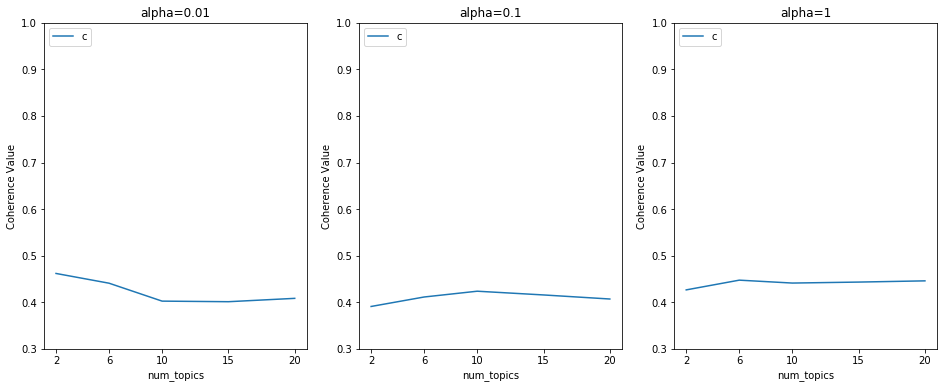

In [20]:
# plot
def plot_coherence(coherence_df, alpha_range, num_topics_range):
    plt.figure(figsize=(16,6))

    for i, val in enumerate(alpha_range):

        # subplot 1/3/i
        plt.subplot(1, 3, i+1)
        alpha_subset = coherence_df[coherence_df['alpha']==val]

        plt.plot(alpha_subset["num_topics"], alpha_subset["coherence_value"])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title("alpha={0}".format(val))
        plt.ylim([0.30, 1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)

plot_coherence(coherence_df, alpha_range, num_topics_range)